In [3]:
# Decision Tree Model for Predicting Vaccine Probabilities with Categorical Handling

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.multioutput import MultiOutputClassifier

In [4]:
# Load the datasets
X_train_df = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
training_set_labels_df = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
X_test_df = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')



In [5]:
# Check and Handle Missing Values
missing_threshold = 0.5  # Drop columns with more than 50% missing values
missing_percentages = X_train_df.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index

print(f"Dropping columns with more than {missing_threshold*100}% missing values:", columns_to_drop.tolist())
X_train_df.drop(columns=columns_to_drop, inplace=True)
X_test_df.drop(columns=columns_to_drop, inplace=True)


Dropping columns with more than 50.0% missing values: ['employment_occupation']


In [6]:
# Handle Categorical Data
categorical_columns = X_train_df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns.tolist())
X_train_df = pd.get_dummies(X_train_df, columns=categorical_columns, drop_first=True)
X_test_df = pd.get_dummies(X_test_df, columns=categorical_columns, drop_first=True)
X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)

Categorical columns: ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry']


In [7]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df
)

In [8]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df
)

In [9]:
# Hyperparameter Grid for Decision Trees
param_grid = {
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

In [10]:
# MultiOutputClassifier with Decision Tree
multi_output_clf = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))

In [11]:
# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=multi_output_clf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    n_jobs=-1  # Use all available cores
)

In [12]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [3, 5, 10, None],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [13]:
# Print Best Parameters and Score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC):", grid_search.best_score_)

Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2}
Best cross-validation score (AUC): 0.8306425214386911


In [14]:
# Best Estimator for Predictions
best_estimator = grid_search.best_estimator_
preds = best_estimator.predict_proba(X_test)

In [15]:
# Convert Predictions to DataFrame
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (5342, 2)


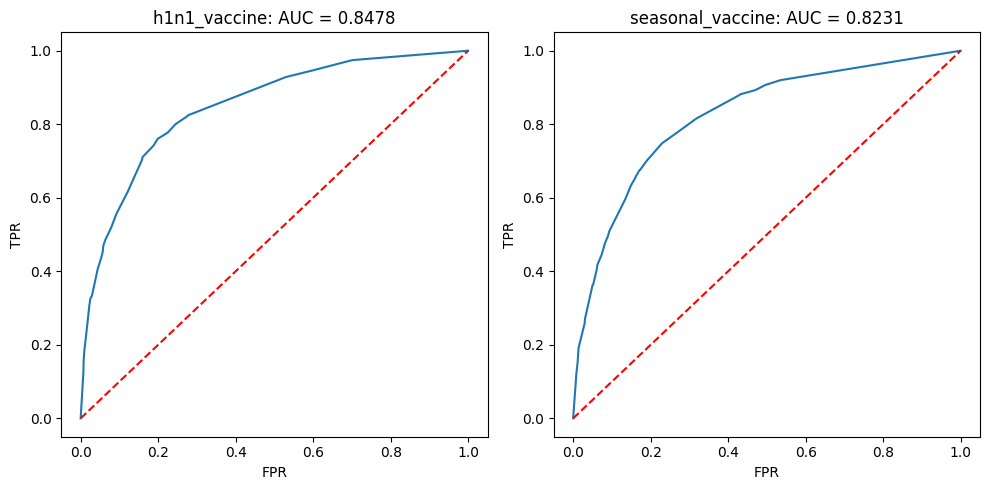

In [16]:
# ROC Curve Plotting
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()

In [17]:
# Final Model Fitting on Full Training Data
best_estimator.fit(X_train_df, training_set_labels_df)
preds = best_estimator.predict_proba(X_test_df)

In [18]:
# Generate Final Predictions
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (26708, 2)


In [19]:
# Save Predictions to CSV
y_preds.to_csv('results/pred_decision_tree_output.csv', index=True)